# Simple Simulation Analysis

In this notebook I will analyse the output of a simple simulation. First, I load the output data of the two stations.

In [1]:
%matplotlib inline

import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from e_sim.sim_components import Simulator
from e_sim.utils import experiment_runner, compute_avg_cost

## Run simulations

Run the simulation for several settings for the batch sizes and rates

In [2]:
# Common settings of the simulation
sim_time = 50

# Settings dict
settings = {}
settings['demand_rate'] = [1]
settings['repair_rate'] = [0.5]
settings['Q_service'] = [1,2]
settings['Q_repair'] = [2, 4]
settings['S_depot'] = [2]
settings['S_warehouse'] = [2]
settings['init_stock_depot'] = [4]
settings['init_stock_warehouse'] = [2, 8]

# Costs
costs = {}
costs['back_order'] = 0.4
costs['holding'] = 0.02
costs['c_service'] = 1
costs['c_repair'] = 2

# Run all combinations of experiments
sim_dfs = experiment_runner(settings, sim_time)

# Save info 
sim_dfs.to_csv('../output/experiment_output.csv')

In [3]:
!pwd
sim_dfs.to_csv('../output/experiment_output.csv')

/Users/markvanderbroek/Documents/Ideas Thesis/Reversed Logistics/code/Simple-RL-Simulation/notebooks


## Visualisation of stock over time

The stock levels of the repairable and servicable units are recorded over time. Let's check these.

In [4]:
# Get a feeling for the data
sim_dfs.head()

,time,service_stock_depot,service_orders,service_back_orders,service_stock_position,repair_stock_depot,service_stock_warehouse,repair_stock_warehouse,items_in_repair,DEMAND,...,SHIP_SERVICE,Q_repair,Q_service,S_depot,S_warehouse,demand_rate,init_stock_depot,init_stock_warehouse,repair_rate,settings
0,1.0,3.0,0.0,0.0,3.0,1.0,2.0,0.0,0.0,1,...,0,2,1,2,2,1,4,2,0.5,"Q_repair=2, Q_service=1, S_depot=2, S_warehous..."
1,2.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,1,...,0,2,1,2,2,1,4,2,0.5,"Q_repair=2, Q_service=1, S_depot=2, S_warehous..."
2,3.0,1.0,1.0,0.0,2.0,1.0,0.0,1.0,1.0,1,...,0,2,1,2,2,1,4,2,0.5,"Q_repair=2, Q_service=1, S_depot=2, S_warehous..."
3,3.5,1.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,0,...,0,2,1,2,2,1,4,2,0.5,"Q_repair=2, Q_service=1, S_depot=2, S_warehous..."
4,4.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1,...,2,2,1,2,2,1,4,2,0.5,"Q_repair=2, Q_service=1, S_depot=2, S_warehous..."


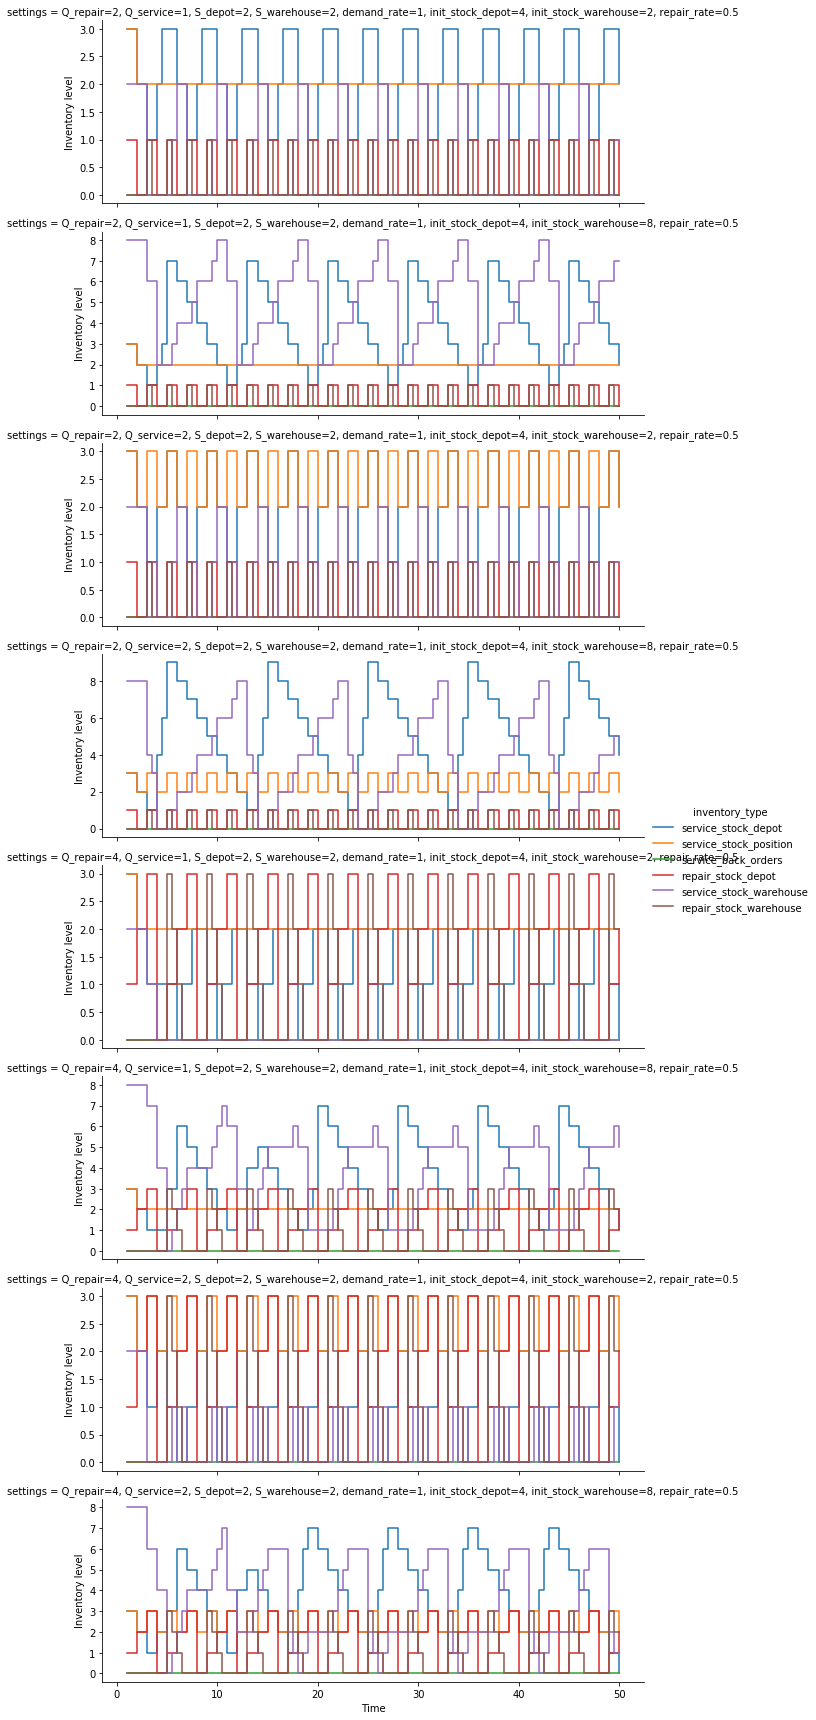

In [5]:
# Get all relevant inventory level variables
# Create long format
inventory_data = sim_dfs.melt(value_vars=['service_stock_depot', 'service_stock_position', 'service_back_orders', 'repair_stock_depot', 'service_stock_warehouse', 'repair_stock_warehouse'], 
                              id_vars=['time', 'settings'],
                              value_name='inventory_level', var_name='inventory_type'
                              )

# Plot lines over time 
g = sns.FacetGrid(inventory_data[inventory_data.time >= 0], col='settings', col_wrap=1, hue='inventory_type', aspect=3, sharey=False)

# Plot lines
g.map(plt.step, 'time', 'inventory_level', where='post').add_legend().set_axis_labels('Time', 'Inventory level')

## Compute the average cycle cost

In this simple model, we assume that sending a batch from the warehouse to the depot has a cost `c_d` and sending a batch of repairable units from the depot to the warehouse costs `c_r`. In general we have that `c_r` > `c_d`, since the reverse flow is typically less efficient. Besides, set-up costs for orders, a holding costs of `h_d` per unit per unit of time for stock of servicable units at the depot has to be paid. In case of a shortage, a backlogging cost of `b_d` per unit per unit of time is incurred. For now, I do not assume any holding cost for the repairable units.

In [8]:
# Transform data types to float
df_avg_cost = sim_dfs.groupby(list(settings.keys())).apply(compute_avg_cost, costs)

### Average inventory levels per cycle

In [9]:
df_avg_cost.head()

demand_rate  repair_rate  Q_service  Q_repair  S_depot  S_warehouse  init_stock_depot  init_stock_warehouse
1            0.5          1          2         2        2            4                 2                       1.9224
                                                                                       8                       1.9248
                                     4         2        2            4                 2                       1.4024
                                                                                       8                       1.4248
                          2          2         2        2            4                 2                       1.4424
dtype: float64